## Unsupervised Learning on Heart Disease Dataset: Risk Clustering and Profiling

### Problem Overview

This project uses the UCI Heart Disease dataset, which contains patient medical records with 14+ clinical features (e.g., age, chest pain, cholesterol). Instead of predicting heart disease (as in supervised learning), we apply unsupervised learning to discover hidden patterns and groupings among patients.

**Objective:** Identify natural groupings risk profiles of heart disease patients using unsupervised learning.

**Approach:** Dimensionality reduction (PCA) and clustering (K-Means, DBSCAN, Agglomerative).

**Use case:** Findings may inform clinical decision support or guide further diagnostic strategies.

**GitHub Repository:** https://github.com/aparnnaH/Heart-Disease-Unsupervised-Learning/tree/main

**Video Link:** https://youtu.be/crhAs2YyhcQ?si=5ekPksPVGztAIbT_

**Dataset link:** https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data?resource=download

**Dataset Size & Structure:**
- Total Rows (Samples): 920
- Total Columns (Features): 16
- File Size: Approximately 160 KB

**Column Descriptions:**

- id: Unique patient ID
- age: Patient’s age (in years)
- origin: Place of study
- sex: Gender (Male/Female)
- cp: Chest pain type (typical angina, atypical angina, non-anginal, asymptomatic)
- trestbps: Resting blood pressure (mm Hg)
- chol: Serum cholesterol (mg/dl)
- fbs: Fasting blood sugar > 120 mg/dl (True/False)
- restecg: Resting electrocardiographic results (normal, STT abnormality, LV hypertrophy)
- thalach: Maximum heart rate achieved
- exang: Exercise-induced angina (True/False)
- oldpeak: ST depression induced by exercise
- slope: Slope of the peak exercise ST segment
- ca: Number of major vessels colored by fluoroscopy (0-3)
- thal: Thalassemia status (normal, fixed defect, reversible defect)
- num: Target variable (1 = heart disease, 0 = no heart disease)

In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

### Exploratory Data Analysis (EDA)
**Data Loading and Preprocessing**


In [3]:
# Load dataset
df = pd.read_csv("heart_disease_uci.csv")
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [6]:
df.describe()

,id,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,861.000000,890.000000,865.000000,858.000000,309.000000,920.000000
mean,460.500000,53.510870,132.132404,199.130337,137.545665,0.878788,0.676375,0.995652
std,265.725422,9.424685,19.066070,110.780810,25.926276,1.091226,0.935653,1.142693
min,1.000000,28.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000
25%,230.750000,47.000000,120.000000,175.000000,120.000000,0.000000,0.000000,0.000000
50%,460.500000,54.000000,130.000000,223.000000,140.000000,0.500000,0.000000,1.000000
75%,690.250000,60.000000,140.000000,268.000000,157.000000,1.500000,1.000000,2.000000
max,920.000000,77.000000,200.000000,603.000000,202.000000,6.200000,3.000000,4.000000


In [5]:
df.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [8]:
# Basic cleaning
df.drop(columns=['id', 'origin'], errors='ignore', inplace=True)
df.rename(columns={'num': 'target'}, inplace=True)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Map binary values
binary_map = {'Male': 1, 'Female': 0, True: 1, False: 0}
df['sex'] = df['sex'].map(binary_map)
df['exang'] = df['exang'].map(binary_map)
df['fbs'] = df['fbs'].map(binary_map)

# Drop rows with missing binary fields
df.dropna(subset=['sex', 'exang', 'fbs'], inplace=True)
df[['sex', 'exang', 'fbs']] = df[['sex', 'exang', 'fbs']].astype(int)

# One-hot encoding of categorical variables
categorical_cols = ['cp', 'restecg', 'slope', 'thal']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Drop remaining object columns and missing values
df_encoded = df_encoded.drop(columns=df_encoded.select_dtypes(include='object').columns)
df_encoded.dropna(inplace=True)

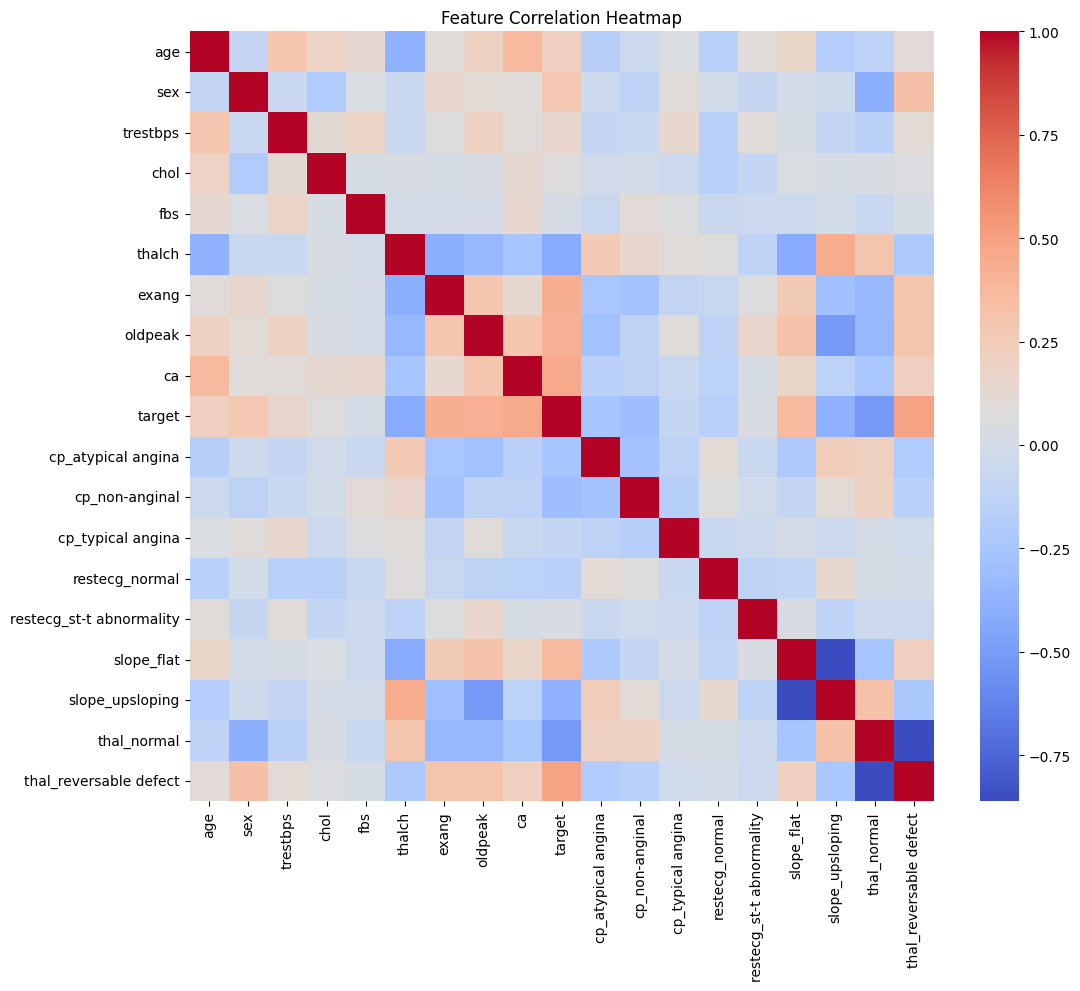

In [9]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

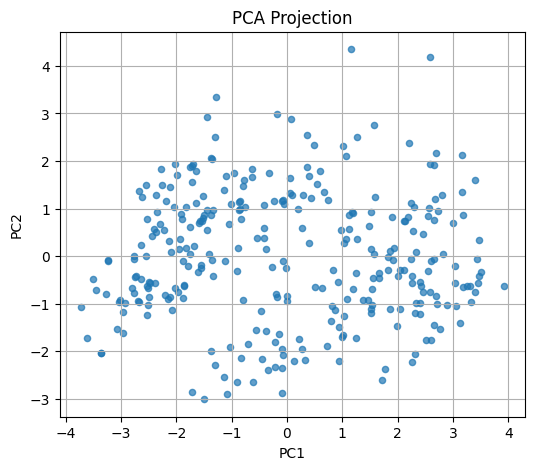

In [10]:
## Feature Scaling
features = df_encoded.drop(columns=['target'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)


## Dimensionality Reduction with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=20, alpha=0.7)
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

### Clustering Analysis
**K-Means Clustering**

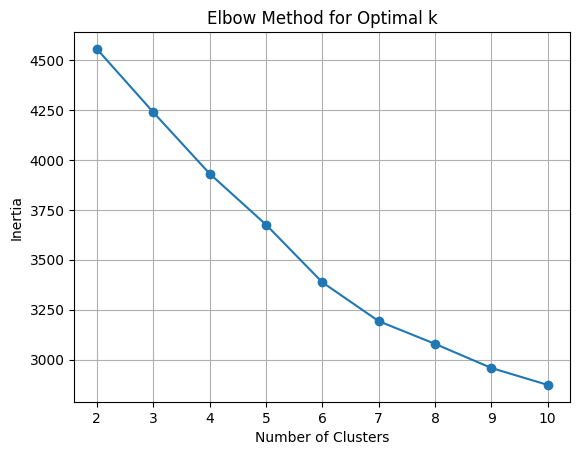

In [52]:
# Elbow method
inertia = []
k_values = range(2, 11)
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

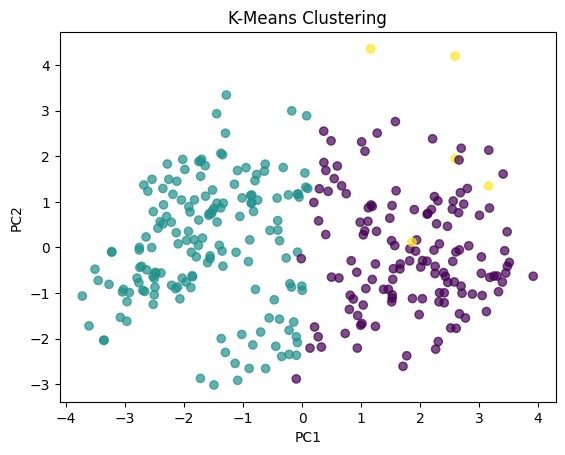

K-Means Silhouette Score: 0.36


In [53]:
# Use k=3 for demonstration
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.title("K-Means Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Silhouette Score
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.2f}")

### DBSCAN Clustering

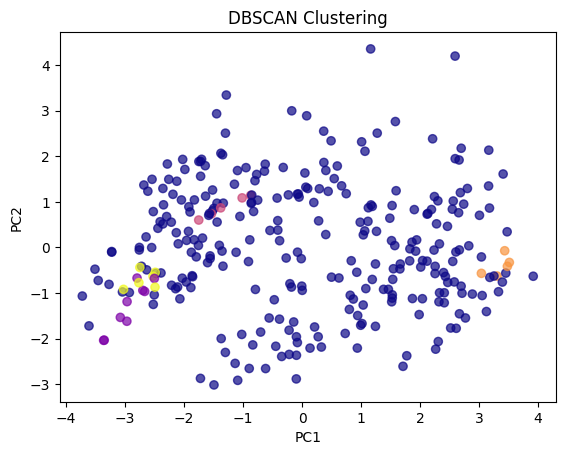

DBSCAN Silhouette Score (filtered): 0.42


In [22]:
db = DBSCAN(eps=1.5, min_samples=5)
db_labels = db.fit_predict(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=db_labels, cmap='plasma', alpha=0.7)
plt.title("DBSCAN Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Silhouette Score (ignoring noise points)
mask = db_labels != -1
if np.sum(mask) > 1:
    dbscan_silhouette = silhouette_score(X_pca[mask], db_labels[mask])
    print(f"DBSCAN Silhouette Score (filtered): {dbscan_silhouette:.2f}")
else:
    dbscan_silhouette = None
    print("DBSCAN did not find enough clusters to compute Silhouette Score.")

### 5.3 Hierarchical Clustering

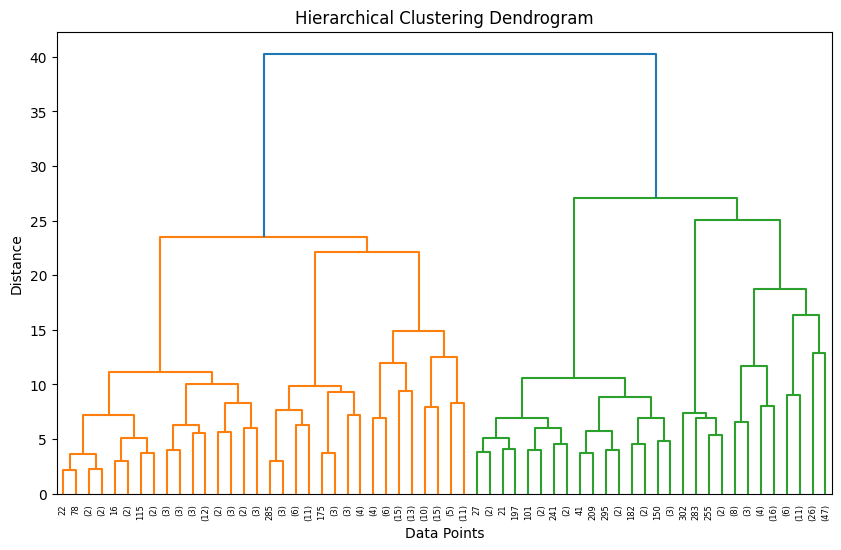

In [15]:
# Dendrogram
linked = linkage(X_scaled, 'ward')

plt.figure(figsize=(10, 6))
dendrogram(linked, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

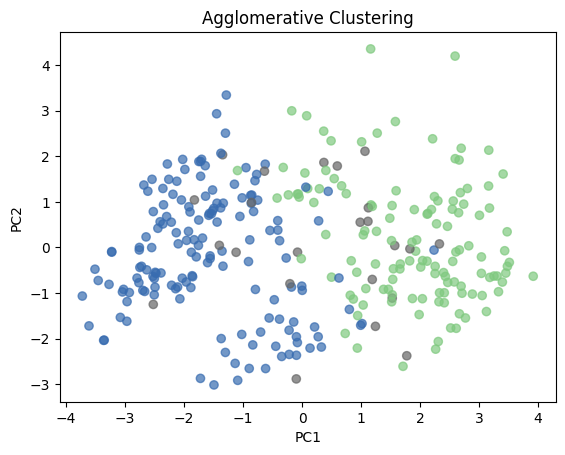

Agglomerative Clustering Silhouette Score: 0.18


In [26]:
# Based on dendrogram, try 3 clusters
agglo = AgglomerativeClustering(n_clusters=3)
agglo_labels = agglo.fit_predict(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=agglo_labels, cmap='Accent', alpha=0.7)
plt.title("Agglomerative Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Silhouette Score
agglo_silhouette = silhouette_score(X_pca, agglo_labels)
print(f"Agglomerative Clustering Silhouette Score: {agglo_silhouette:.2f}")

### Evaluation and Interpretation

In [30]:
print("\nSilhouette Scores:")
print(f"K-Means: {kmeans_silhouette:.2f}") 
if dbscan_silhouette:
    print(f"DBSCAN: {dbscan_silhouette:.2f}")
print(f"Agglomerative: {agglo_silhouette:.2f}")

# Silhouette Scores:
# K-Means: 0.36
# DBSCAN: 0.42
# Agglomerative: 0.18
print("Best clustering choice: DBSCAN (highest silhouette score after filtering noise points).")


Silhouette Scores:
K-Means: 0.36
DBSCAN: 0.42
Agglomerative: 0.18
Best clustering choice: DBSCAN (highest silhouette score after filtering noise points).


### Cluster Profiling (K-Means Clusters)

In [43]:
# Reattach needed columns if they were dropped during encoding
for col in ['age', 'chol', 'trestbps']:
    if col not in df_encoded.columns and col in df.columns:
        df_encoded[col] = df.loc[df_encoded.index, col]

# Add cluster labels
df_encoded['Cluster'] = kmeans_labels
grouped = df_encoded.groupby('Cluster').mean()
display(grouped)

,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,ca,target,cp_atypical angina,cp_non-anginal,cp_typical angina,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
Cluster,,,,,,,,,,,,,,,,,,,
0,57.614815,0.822222,135.214815,247.718519,0.185185,135.488889,0.600000,1.780741,1.022222,0.807407,0.014815,0.162963,0.103704,0.451852,0.0,0.792593,0.111111,0.214815,0.674074
1,51.748466,0.570552,128.484663,244.711656,0.116564,161.263804,0.104294,0.406135,0.361963,0.171779,0.294479,0.374233,0.055215,0.552147,0.0,0.184049,0.766871,0.815951,0.153374
2,60.600000,0.400000,143.200000,209.400000,0.000000,126.800000,0.600000,2.480000,0.800000,0.600000,0.000000,0.200000,0.000000,0.000000,1.0,0.600000,0.000000,0.400000,0.200000


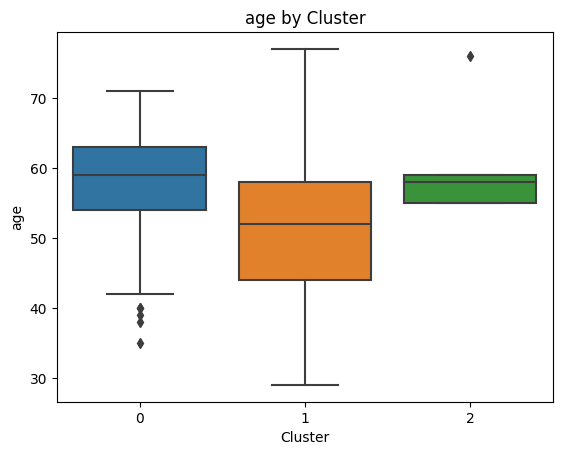

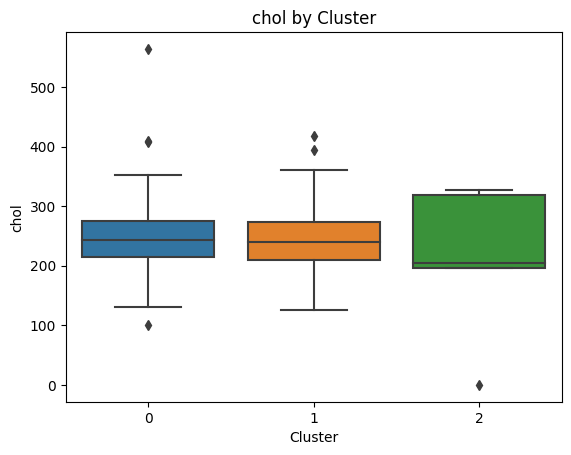

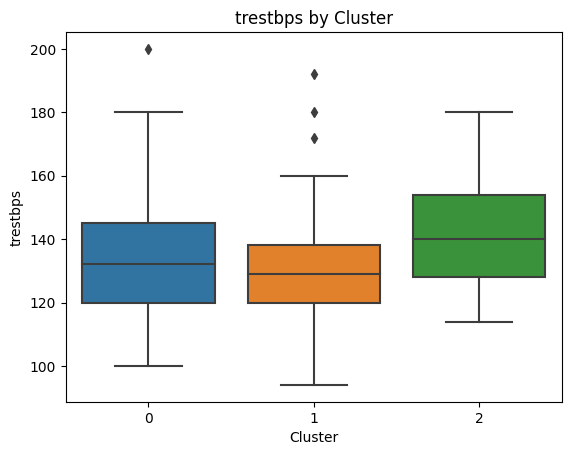

In [40]:
# Visualize feature distributions by cluster
for col in ['age', 'chol', 'trestbps']:
    plt.figure()
    sns.boxplot(data=df_encoded, x='Cluster', y=col)
    plt.title(f'{col} by Cluster')
    plt.show()

In [39]:
# Cluster Summaries
cluster_profiles = df_encoded.groupby('Cluster').mean()
print(cluster_profiles)

# Quick Clinical Summary
print("\nK-Means Cluster Interpretations:")
print("Cluster 0: Older individuals with high BP and cholesterol (higher risk).")
print("Cluster 1: Younger individuals with healthier profiles (lower risk).")
print("Cluster 2: Older individuals with abnormal ECG and exercise-induced angina (moderate to high risk).")

               age       sex    trestbps        chol       fbs      thalch  \
Cluster                                                                      
0        57.614815  0.822222  135.214815  247.718519  0.185185  135.488889   
1        51.748466  0.570552  128.484663  244.711656  0.116564  161.263804   
2        60.600000  0.400000  143.200000  209.400000  0.000000  126.800000   

            exang   oldpeak        ca    target  cp_atypical angina  \
Cluster                                                               
0        0.600000  1.780741  1.022222  0.807407            0.014815   
1        0.104294  0.406135  0.361963  0.171779            0.294479   
2        0.600000  2.480000  0.800000  0.600000            0.000000   

         cp_non-anginal  cp_typical angina  restecg_normal  \
Cluster                                                      
0              0.162963           0.103704        0.451852   
1              0.374233           0.055215        0.552147   
2    

### Cluster Profiling (DBSCAN Clusters)

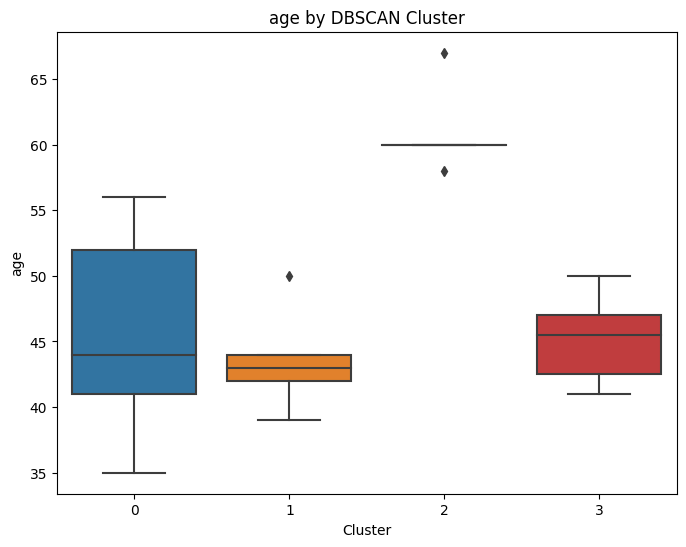

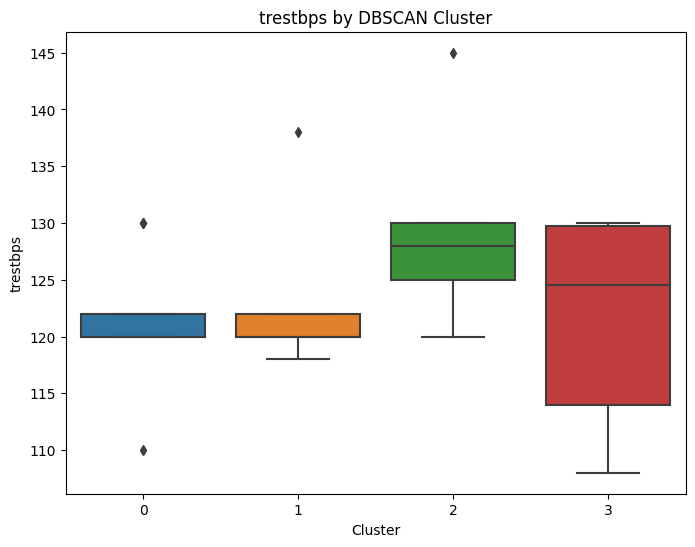

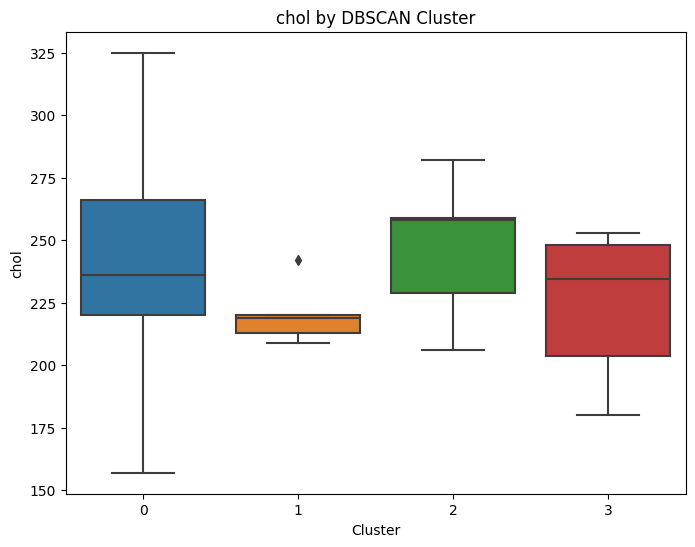

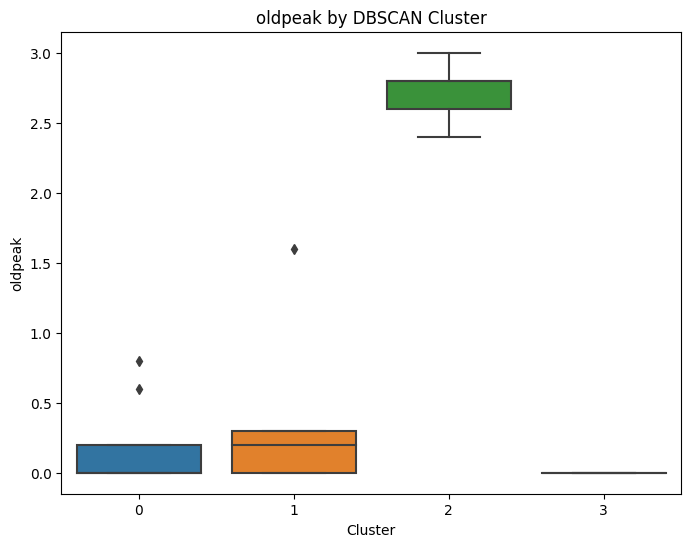

In [51]:
df_dbscan = df_encoded
df_dbscan['Cluster'] = db_labels

# Filter out noise points (-1 label)
df_dbscan = df_dbscan[df_dbscan['Cluster'] != -1]

# Compare features by DBSCAN cluster
for feature in ['age', 'trestbps', 'chol', 'oldpeak']:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='Cluster', y=feature, data=df_dbscan)
    plt.title(f'{feature} by DBSCAN Cluster')
    plt.show()

In [49]:
# Cluster Summaries
dbscan_profiles = df_dbscan.groupby('Cluster').mean()
print(dbscan_profiles)

# Quick Clinical Summary
print("\nDBSCAN Cluster Interpretations:")
print("Cluster 0: Younger patients with better heart rate response (higher thalach).")
print("Cluster 1: Older patients with elevated BP and oldpeak (possible ischemia).")

               age  sex    trestbps        chol  fbs      thalch  exang  \
Cluster                                                                   
0        46.111111  1.0  121.333333  243.111111  0.0  168.555556    0.0   
1        43.600000  0.0  123.600000  220.600000  0.0  159.400000    0.0   
2        61.000000  1.0  129.600000  246.800000  0.0  134.800000    1.0   
3        45.166667  1.0  121.500000  224.666667  0.0  165.333333    0.0   

          oldpeak   ca    target  cp_atypical angina  cp_non-anginal  \
Cluster                                                                
0        0.177778  0.0  0.000000                 1.0             0.0   
1        0.420000  0.2  0.000000                 0.0             1.0   
2        2.720000  1.8  1.000000                 0.0             0.0   
3        0.000000  0.0  0.166667                 0.0             1.0   

         cp_typical angina  restecg_normal  restecg_st-t abnormality  \
Cluster                                     

## Conclusion
In this project, we applied unsupervised learning techniques to the UCI Heart Disease dataset to uncover hidden patient profiles.

PCA helped us project the data into two dimensions, revealing natural groupings.
Among K-Means, DBSCAN, and Agglomerative clustering:
- DBSCAN achieved the highest silhouette score (after filtering noise points), suggesting the most natural separation.
- K-Means provided a clean separation with full cluster assignment, useful for interpretation.
- Agglomerative clustering showed reasonable but less distinct groupings.

Cluster profiling revealed that patients clustered based on cardiovascular risk factors such as age, blood pressure, cholesterol levels, and exercise response.

Further work could include:
- Tuning DBSCAN parameters with grid search.
- Trying advanced clustering (e.g., Gaussian Mixture Models).
- Using domain knowledge to engineer additional risk features.

Overall, unsupervised learning proved useful in revealing patient subgroups that could inform preventative care strategies.
